In [1]:
# %matplotlib notebook

In [2]:
import gymnasium as gym
import gymnasium_env
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter

In [3]:
# env = gym.make("gym_examples/GridWorld-v0", render_mode="rgb_array")
env = gym.make("gymnasium_env/CliffWalker", render_mode="rgb_array")

In [4]:
# QTable
numstates = (env.observation_space["agent"].high[0] + 1) * (
    env.observation_space["agent"].high[1] + 1
)
numactions = env.action_space.n

#qtable = np.random.rand(numstates, numactions).tolist()
qtable = np.zeros((numstates,numactions)).tolist()
qtable[-1][0] = 0
qtable[-1][1] = 0
qtable[-1][2] = 0
qtable[-1][3] = 0

In [5]:
# hyperparameters
episodes = 100
gamma = 0.1
epsilon = 0.08
decay = 0.01
alpha = 1.0

In [6]:
#these variables represent the state that gets updated by the update function
#another variable, dot_artist, is the red dot artist
steps = 0
cumulative_reward = 0
state = 0
terminated = True
truncated = False
episodes = 0

# the update function replaces the old for loop: for e in range(episodes):
#update function for the animation
def updatefun(frame):
    global terminated
    global truncated
    global epsilon
    global steps
    global state
    global cumulative_reward
    global episodes
    if terminated or truncated:
        #print("episodes #", frame, "/", episodes)
        episodes += 1
        terminated = False
        truncated = False
        
        observation, info = env.reset()

        epsilon -= decay * epsilon
        #print("Done in", steps, "steps\n".format(steps))
        steps = 0
        cumulative_reward = 0
        state = 12 * observation["agent"][1] + observation["agent"][0]

#    while not terminated or truncated:
    if np.random.uniform() < epsilon:
        action = env.action_space.sample()
    else:
        action = qtable[state].index(max(qtable[state]))

    observation, reward, terminated, truncated, info = env.step(action)

    next_state = 12 * observation["agent"][1] + observation["agent"][0]
    qtable[state][action] = qtable[state][action] + alpha * (reward + gamma * max(qtable[next_state]) - qtable[state][action])
    
    # update the artists for the animation
    # first identify which artists need updating
    triangle_artist = triangle_list[state*4+action]
    text_artist = text_list[state*4+action]
    
    # then update the artists
    triangle_artist.set(color=cmap(norm(qtable[state][action])))
    text_artist.set(text=f"{qtable[state][action]:.4f}")

    state = next_state
    
    # place the dot at the next state
    x = state % 12
    y = state // 12
    dot_artist.set_center((x+0.5,-y-0.5))

    steps += 1
    cumulative_reward += reward
    
    # update the title
    ax.set_title(f"Q-Table Map Episode {episodes} steps {steps} reward {cumulative_reward}")
    
    # return the artists that need to be updated in the animation
    return triangle_artist, text_artist, dot_artist

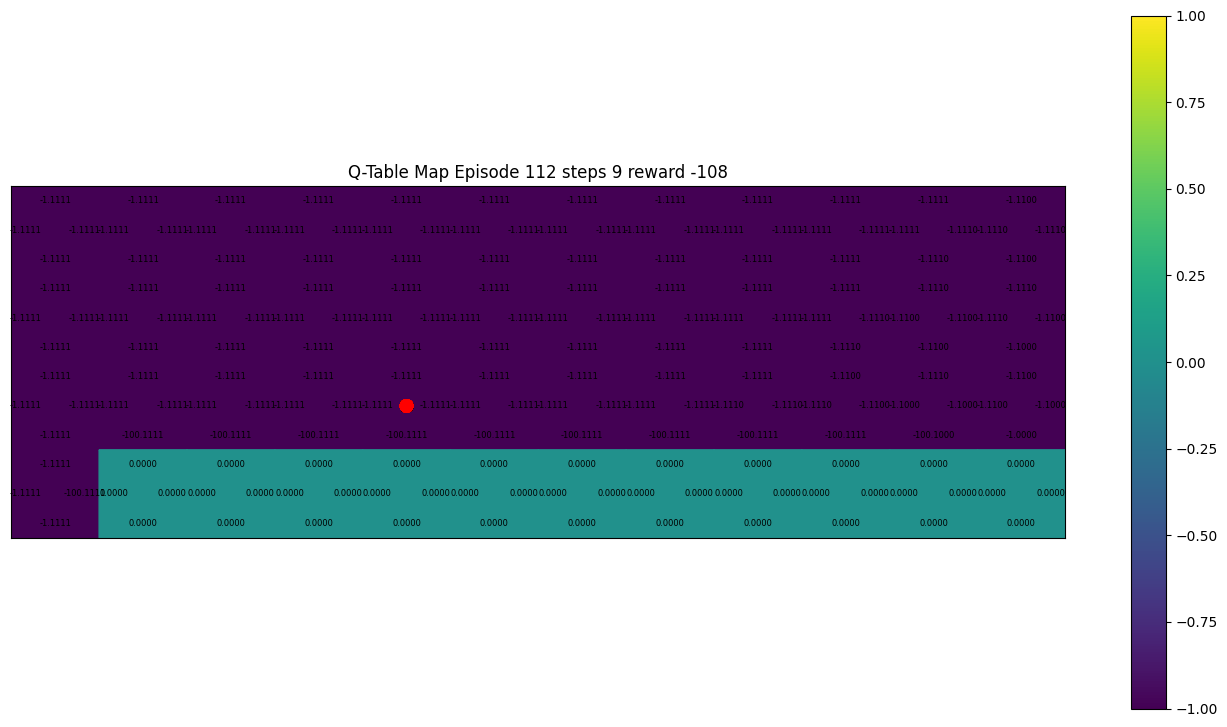

In [7]:
# Plot and animate the Q-Table
triangle_list = [] # keep track of the triangle artists
text_list = [] # keep track of the text artists
dot_artist = patches.Circle((0.5, -3.5), 0.07, color='r',fill=True) # the travelling dot artist

fig, ax = plt.subplots(figsize=(17, 9))
norm = Normalize(vmin=-1, vmax=1)
cmap = plt.get_cmap("viridis")
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
for i in range(numstates):
    x = i % 12
    y = i // 12
    for j in range(numactions):
        if j == 0:  # right
            points = [(x + 0.5, -y - 0.5), (x + 1, -y - 1), (x + 1, -y)]
        elif j == 1:  # top
            points = [(x + 0.5, -y - 0.5), (x + 1, -y - 1), (x, -y - 1)]
        elif j == 2:  # left
            points = [(x + 0.5, -y - 0.5), (x, -y - 1), (x, -y)]
        elif j == 3:  # down
            points = [(x + 0.5, -y - 0.5), (x, -y), (x + 1, -y)]
        triangle = patches.Polygon(
            (points), closed=True, color=cmap(norm(qtable[i][j]))
        )
        triangle_list.append(triangle) # keep track of the triangle artists for the animation
        ax.add_patch(triangle)
        center_of_points = np.mean(points, axis=0)
        text_list.append( # keep track of the text artists for the animation
            ax.text( 
                center_of_points[0],
                center_of_points[1],
                f"{qtable[i][j]:.4f}",
                ha="center",
                va="center",
                color="black",
                fontsize=6,
            )
        )
        
        ax.add_patch(dot_artist)

ax.set_title("Q-Table Map")
ax.set_xlim([0, 12])
ax.set_ylim([-(numstates // 12), 0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("equal")
plt.colorbar(sm, ax=ax)

# showtime!  display the animation of fig using the update function, pausing between calls (interval milliseconds)
ani = animation.FuncAnimation(fig=fig, func=updatefun, frames=2500, interval=50, blit=True)
writer = FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
ani.save("traditional.mp4", writer=writer)
# plt.show()